In [10]:
import json
import math

In [11]:
# Load training data
list_data = []
with open("./resources/annotations.json", 'r') as f:
    list_data = json.load(f)

# Ambil hanya annotation
annotations = list_data['annotations']

# dapatkan total jumlah annotation
len_annotations = len(annotations)
print(f"Jumlah annotations adalah {len_annotations}")

# split annotation menjadi 8:2
len_training_annotations = math.floor(len_annotations * .01)
training_annotations = annotations[:len_training_annotations]
test_annotations = annotations[len_training_annotations:]
print(f"Jumlah training annotations adalah {len_training_annotations}")
print(f"Jumlah test annotations adalah {len_annotations-len_training_annotations}")

Jumlah annotations adalah 254
Jumlah training annotations adalah 2
Jumlah test annotations adalah 252


In [12]:
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm

# Load spacy model baru
nlp = spacy.blank("id")
db = DocBin()


# referensi: https://turbolab.in/build-a-custom-ner-model-using-spacy-3-0/
# referensi: https://agateteam.org/spacynerannotate/
# Proses load data annotation menjadi format spacy
for text, annot in training_annotations:
    doc = nlp(text)
    ents = []
    for (start, end, label) in annot["entities"]:
        span = doc.char_span(start, end, label=label)
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    try:
        doc.ents = ents
        db.add(doc)
    except:
        print(text, annot)

# simpan data dengan format spacy
db.to_disk("./output/train.spacy")

In [13]:
import subprocess

# Membuat config dengan menggunakan base_config.cfg
# python -m spacy init fill-config base_config.cfg config.cfg
process = subprocess.run(['python', '-m', 'spacy', 'init', 'fill-config',
                         './resources/base_config.cfg', './output/config.cfg'], capture_output=True)
output = process.stdout.decode()

print(output)

✔ Auto-filled config with all values
✔ Saved config
output/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy



In [14]:
import subprocess
import os

def func_training_model(located, force = False):
    # Training data
    # python -m spacy train config.cfg --output ./output
    if os.path.exists(located) == False or force:
        process = subprocess.run(['python', '-m', 'spacy', 'train',
                                './output/config.cfg', '--output', located], capture_output=True)
        output = process.stdout.decode()
        # Butuh waktu sekitar 18 menit an
        print(output)
    else:
        print('Training already success')

func_training_model("./models", False)

Training already success


In [15]:
# Testing data

# Proses load data annotation menjadi format spacy
for text, annot in test_annotations:
    doc = nlp(text)
    ents = []
    for (start, end, label) in annot["entities"]:
        span = doc.char_span(start, end, label=label)
        if span is None:
            print("Skipping entity")
        else:
            ents.append(span)
    try:
        doc.ents = ents
        db.add(doc)
    except:
        print(text, annot)

# simpan data dengan format spacy
db.to_disk("./output/test.spacy")

In [16]:
import spacy
from spacy.scorer import Scorer
from spacy.training import Example


nlp = spacy.load('./models/model-last/')
examples = []


for text, annotations in test_annotations:
    doc_pred = nlp(text)
    example = Example.from_dict(doc_pred, annotations)
    examples.append(example)


scorer = Scorer(nlp)
scores = scorer.score(examples)

print(examples)
print((scores))
print(f"Precision = {scores['ents_p']}")
print(f"Recall = {scores['ents_r']}")
print(f"F1-Score = {scores['ents_f']}")

[{'doc_annotation': {'cats': {}, 'entities': ['O', 'O', 'O', 'U-DATE', 'O', 'O', 'O', 'U-DATE', 'O', 'O', 'O', 'B-PERSON', 'L-PERSON', 'O', 'O', 'U-DATE', 'O', 'O', 'O', 'O'], 'spans': {}, 'links': {}}, 'token_annotation': {'ORTH': ['nuwus', 'titik', 'rawan', 'malam', 'disaat', 'gerimis', 'pulang', 'mlm', 'hnya', 'berniat', 'dolen', 'pekerja', 'wanita', 'kena', 'shift', 'sore', 'plg', 'seputar', 'jam', '\r'], 'SPACY': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'POS': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'MORPH': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'HEAD': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'DEP': ['', '',

In [29]:

chart_kejahatan = {
  'narkoba': 0,
  'pembunuhan': 0,
  'pemerkosaan': 0,
  'pencurian': 0,
  'penipuan': 0,
  'lainnya': 0
}
chart_wilayah = {
  'kabmalang': 0,
  'lowokwaru': 0,
  'klojen': 0,
  'blimbing': 0,
  'kedungkandang': 0,
  'sukun': 0,
}

def kategorikanWilayah(entity):
    wilayah = None
    for ent in entity:
        if ent[3] == 'LOCATION':
            lokasi = ent[0].lower()
            if "lowokwaru" in lokasi:
                wilayah = "lowokwaru"
                break
            elif "klojen" in lokasi:
                wilayah = "klojen"
                break
            elif "blimbing" in lokasi:
                wilayah = "blimbing"
                break
            elif "kedungkandang" in lokasi:
                wilayah = "kedungkandang"
                break
            elif "kedung kandang" in lokasi:
                wilayah = "kedungkandang"
                break
            elif "sukun" in lokasi:
                wilayah = "sukun"
                break
    if wilayah == None:
        chart_wilayah['kabmalang'] += 1
    else:
        chart_wilayah[wilayah] += 1

def kategorikanKejahatan(entity):
    kejahatan = None
    for ent in entity:
        if ent[3] == 'CRIME':
            tindakan = ent[0].lower()
            if "curi" in tindakan:
                kejahatan = "pencurian"
                break
            if "maling" in tindakan:
                kejahatan = "pencurian"
                break
            if "hilang" in tindakan:
                kejahatan = "pencurian"
                break
            elif "obat" in tindakan:
                kejahatan = "narkoba"
                break
            elif "bandar" in tindakan:
                kejahatan = "narkoba"
                break
            elif "kurir" in tindakan:
                kejahatan = "narkoba"
                break
            elif "sabu" in tindakan:
                kejahatan = "narkoba"
                break
            elif "perkosa" in tindakan:
                kejahatan = "pemerkosaan"
                break
            elif "pemerkosaan" in tindakan:
                kejahatan = "pemerkosaan"
                break
            elif "cabul" in tindakan:
                kejahatan = "pemerkosaan"
                break
            elif "cabul" in tindakan:
                kejahatan = "pemerkosaan"
                break
            elif "bejat" in tindakan:
                kejahatan = "pemerkosaan"
                break
            elif "bunuh" in tindakan:
                kejahatan = "pembunuhan"
                break
            elif "tewas" in tindakan:
                kejahatan = "pembunuhan"
                break
            elif "penipu" in tindakan:
                kejahatan = "penipuan"
                break
            elif "tipu" in tindakan:
                kejahatan = "penipuan"
                break
    if kejahatan is not None:
        chart_kejahatan[kejahatan] += 1
    else:
        chart_kejahatan['lainnya'] += 1


In [30]:
def get_entities(doc):
    return [(ent.text, ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]


def evaluate_ner(model, test_data):
    correct_entities = 0
    total_entities = 0

    for text, annotations in test_data:
        true_entities = annotations['entities']
        total_entities += len(true_entities)

        doc = model(text)
        pred_entities = get_entities(doc)
        
        # Kategorikan
        kategorikanWilayah(pred_entities)
        kategorikanKejahatan(pred_entities)

        for entity in pred_entities:
            ent = []
            ent.append(entity[1])
            ent.append(entity[2])
            ent.append(entity[3])
            if ent in true_entities:
                correct_entities += 1

    entity_accuracy = correct_entities / total_entities if total_entities > 0 else 0
    return entity_accuracy


# Evaluate the model
entity_accuracy = evaluate_ner(nlp, test_data=test_annotations)
print(f"Entity-level Accuracy: {entity_accuracy:.2f}")

Entity-level Accuracy: 0.97


In [25]:
import pandas as pd


df = pd.read_csv("./resources/FIX.csv")
new_df = df[['full_text']]

new_df.to_csv("./resources/upload.csv", index=False)

Text(0, 0.5, 'Jumlah')

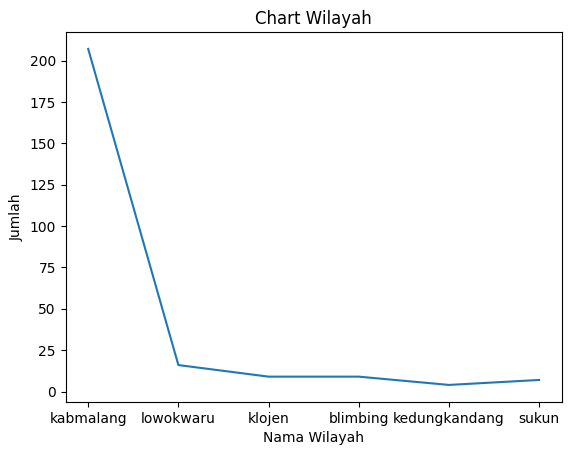

In [37]:
import matplotlib.pyplot as plt

plt.plot(chart_wilayah.keys(), chart_wilayah.values())  
# Add title and axis labels
plt.title("Chart Wilayah")
plt.xlabel("Nama Wilayah")
plt.ylabel("Jumlah")
 

Text(0, 0.5, 'Jumlah')

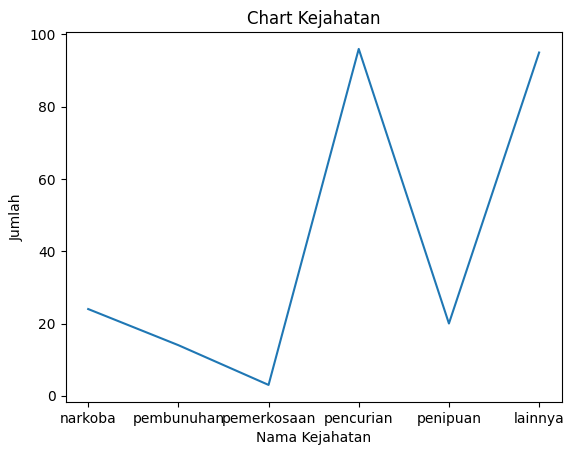

In [38]:
import matplotlib.pyplot as plt

plt.plot(chart_kejahatan.keys(), chart_kejahatan.values())  
# Add title and axis labels
plt.title("Chart Kejahatan")
plt.xlabel("Nama Kejahatan")
plt.ylabel("Jumlah")
 